## collecting data

In this notebook I will create a data set about movies from a base at filmweb.pl using a BeautifulSoup and try to predict a rating of movies.

In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
#function getting information about 1 film

def get_info(link):
    
    r=requests.get(link)
    soup=bs(r.content)

    movie_info={}
    
    #info about directors,...,premiere 
    info_box=soup.find(class_='filmPosterSection__info filmInfo')

    keys=info_box.find_all(class_='filmInfo__header')
    values=info_box.find_all(class_='filmInfo__info')

    for i in range(5):
        key=keys[i].get_text(strip=True).split('(')[0]
        value=values[i].get_text(strip=True).split('(')[0]
        movie_info[key]=value
        
    #info about title and actors
    for i in range(10):
        try:
            base_link='https://www.filmweb.pl'
            actors_link=base_link+soup.find_all(class_='page__moreButton')[i].a['href']

            r2=requests.get(actors_link)
            soup2=bs(r2.content)

            movie_info['title']=soup2.find(class_='filmHeaderSection__title').get_text(strip=True)

            actors_table=soup2.find(class_='filmFullCastSection__list')
            actors_rows=actors_table.find_all(class_='castRoleListElement__info')
            movie_info['actors']=[]

            for index, row in enumerate(actors_rows):
                actor_name=row.a.get_text(strip=True)
                movie_info['actors'].append(actor_name)
                if index>10:
                    break
        except:
            continue

    #info about boxoffice,..., oryginal title
    info_box3=soup.find(class_='filmOtherInfoSection__group')
    info_rows3=info_box3.find_all(class_='filmInfo__group')

    for index, row in enumerate(info_rows3):
        if index<5:
            keys=row.find_all(class_='filmInfo__header')
            values=row.find_all(class_='filmInfo__info')
            for i in range(2):
                try:
                    key2=keys[i].get_text(strip=True).split('(')[0]
                    value2=values[i].get_text(strip=True).split('(')[0]
                    movie_info[key2]=value2
                except:
                    continue
        else:
            break
    
    #info about rating
    movie_info['rating']=soup.find(class_='filmRating__rateValue').get_text(strip=True)
            
    return movie_info

We will use link: https://www.filmweb.pl/films/search?endRate=9&orderBy=rate&descending=true&startCount=8000&startRate=8, and get information about movies with rates from 3.9 to 8.9 stars.

In [3]:
movies_info_list=[]

for l in range(6):
    k=10 #setting number of pages
    j=3+l

    for i in range(k):
        link='https://www.filmweb.pl/films/search?endRate={}'.format(j+1)+'&orderBy=rate&descending=true&startCount=8000'+'&startRate={}'.format(j)+'&page={}'.format(i+1)
        
        r=requests.get(link)
        soup=bs(r.content)
        film_list=soup.select('.wrapperContent.page__section')
        film_rows=film_list[0].find_all('li')

        for index, row in enumerate(film_rows):
            if index<80:
                try:
                    base_link='https://www.filmweb.pl'
                    link=base_link+row.find(class_='filmPreview__titleDetails').a['href']
                    movies_info_list.append(get_info(link))
                except:
                    continue

In [4]:
#creating a DataFrame
df=pd.DataFrame(movies_info_list)

In [5]:
df.columns

Index(['actors', 'boxoffice', 'budÅ¼et', 'budżet', 'data produkcji',
       'dystrybucja', 'gatunek', 'inne tytuÅ‚y', 'inne tytuły', 'na podstawie',
       'premiera', 'produkcja', 'rating', 'reÅ¼yseria', 'reżyseria',
       'scenariusz', 'studio', 'title', 'tytuÅ‚ oryg.', 'tytuł oryg.'],
      dtype='object')

Removing unnecessary columns

In [6]:
df.drop(['budÅ¼et','dystrybucja','inne tytuÅ‚y','inne tytuły','na podstawie','reÅ¼yseria','tytuÅ‚ oryg.','tytuł oryg.'],axis=1
       ,inplace=True)

In [7]:
df=df.rename(columns={'budżet':'budget', 'data produkcji': 'date of production', 'gatunek': 'genre', 'premiera': 'premiere', 
           'produkcja': 'production', 'reżyseria': 'directing','scenariusz': 'scenario'})

In [9]:
df.head()

,actors,boxoffice,budget,date of production,genre,premiere,production,rating,directing,scenario,studio,title
0,"[Anthony Ilott, Chris Jarvis, Aqueela Zoll, Sa...",NaN,NaN,2014,Horror,22 sierpnia 2014,USA,"3,9",Valeri Milev,Frank H. Woodward,UFO International Productions,Droga bez powrotu 6: Hotel na uboczu
1,"[Piotr Stramowski, Mikołaj Roznerski, Katarzyn...",NaN,NaN,2019,Dramat/Sportowy,15 lipca 2019,Polska,"3,9",Konrad Maximilian,Konrad Maximilian,Domino Film/Exotic Car Club Sp. z o.o.,Fighter
2,"[Michał Żebrowski, Zbigniew Zamachowski, Macie...",NaN,NaN,2001,Fantasy/Przygodowy,9 listopada 2001,Polska,"3,9",Marek Brodzki,Michał Szczerbic,Héritage Films,Wiedźmin
3,"[Jess Weixler, Hale Appleman, Laila Liliana Ga...",$2 340 110 na świecie$347 578 w USA$1 992 532 ...,NaN,2007,Czarna komedia,19 stycznia 2007,USA,"3,8",Mitchell Lichtenstein,Mitchell Lichtenstein,Teeth,Zęby
4,"[Marlon Wayans, Kali Hawk, Fred Willard, Mike ...",$22 227 514 na świecie$11 686 940 w USA$10 540...,$5 000 000,2016,Komedia,28 stycznia 2016,USA,"3,8",Michael Tiddes,Rick Alvarez/Marlon Wayans,Baby Way Productions/IM Global,Pięćdziesiąt twarzy Blacka


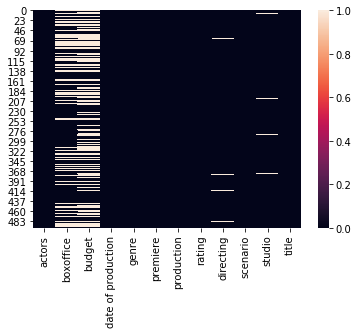

In [10]:
#checking NaN values
sns.heatmap(df.isnull())

There is a lot of NaN values in budget and boxoffice columns so we will create 1 additional DataFrame without this colmns. We will remove rows with NaN values in studio and directing.

In [11]:
#df1 will be a dataFrame without budget and boxoffice columns
df1=df.copy()

In [12]:
df1.drop(['budget','boxoffice'],axis=1,inplace=True)

In [13]:
df=df[df['directing'].isnull()==False]
df=df[df['studio'].isnull()==False]
df=df[df['budget'].isnull()==False]
df=df[df['boxoffice'].isnull()==False]
df1=df1[df1['directing'].isnull()==False]
df1=df1[df1['studio'].isnull()==False]

In [14]:
df=df.reset_index()
df1=df1.reset_index()

In [15]:
df.drop('index',axis=1,inplace=True)
df1.drop('index',axis=1,inplace=True)

Now we will transform values in some columns. In the 'boxoffice' column we will grab only the first number which is the boxoffice in the world and set a type of this value as float, in the 'budget' column we will remove a dollar sign and also set a type as a float, values in the 'premiere' column will be a datetime objects, in the 'production', 'directing', 'scenario' and 'studio' columns we will have lists of strings instead of one string and we will set a type of rating values as float. Let's define functions in order to do that.

In [16]:
#functions to clean data
def clean_boxoffice(value):
    value= value.split('na')[0].split('$')[1]
    
    for i in range(1):
        try:
            value=value.split('w')[0]
        except:
            continue
    
    return ''.join(value.split())

def clean_scenario(value):
    #changing string into list
    lst=value.split('/')   
    length=len(lst)
    if lst[length-1]=='więcej...':
        del lst[length-1]
    elif lst[length-1]=='Więcej...':
        del lst[length-1]
    
    return lst

def clean_prod(value):
    return value.split(', ')

def clean_studio(value):
    if ' '.join(value).split()[-1]=='Więcej...':
        return ' '.join(value).split()[:-1]
    else:
        return ' '.join(value).split()

def miesiac_ang(miesiac):
    if miesiac=='stycznia' or miesiac=='styczeń':
        return 'January'
    if miesiac=='lutego' or miesiac=='luty':
        return 'February'
    if miesiac=='marca' or miesiac=='marzec':
        return 'March'
    if miesiac=='kwietnia' or miesiac=='kwiecień':
        return 'April'
    if miesiac=='maja' or miesiac=='maj':
        return 'May'
    if miesiac=='czerwca' or miesiac=='czerwiec':
        return 'June'
    if miesiac=='lipca' or miesiac=='lipiec':
        return 'July'
    if miesiac=='sierpnia' or miesiac=='sierpień':
        return 'August'
    if miesiac=='września' or miesiac=='wrzesień':
        return 'September'
    if miesiac=='października' or miesiac=='październik':
        return 'October'
    if miesiac=='listopada' or miesiac=='listopad':
        return 'November'
    if miesiac=='grudnia' or miesiac=='grudzień':
        return 'December'
    
def translating_date(date):
    lst=date.split()
    if len(lst)==3:
        lst[1]=miesiac_ang(date.split()[1])
        return ' '.join(lst)
    else:
        lst[0]=miesiac_ang(date.split()[0])
        return '1 '+' '.join(lst)

def transform_rating(value):
    return '.'.join(value.split(','))

Transforming df

In [17]:
#cleaning 'boxoffice' and 'budget' column
df['boxoffice']=df['boxoffice'].apply(clean_boxoffice)
df['boxoffice']=df['boxoffice'].apply(int)
df['budget']=df['budget'].apply(clean_boxoffice)
df['budget']=df['budget'].apply(float)
df['rating']=df['rating'].apply(transform_rating)
df['date of production']=df['date of production'].apply(float)
df['rating']=df['rating'].apply(float)


#cleaning 'scenario', 'production' and 'directing' column
df['scenario']=df['scenario'].apply(clean_scenario)
df['directing']=df['directing'].apply(clean_scenario)
df['production']=df['production'].apply(clean_scenario)
df['studio']=df['studio'].apply(clean_scenario)

#changing 'premiere' column into datetime object
df['premiere']=df['premiere'].apply(translating_date)
for i in range(df['rating'].count()):
    df['premiere'][i]=datetime.strptime(df['premiere'][i],'%d %B %Y')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Transforming df1

In [18]:
df1['rating']=df1['rating'].apply(transform_rating)
df1['date of production']=df1['date of production'].apply(float)
df1['rating']=df1['rating'].apply(float)

#cleaning 'scenario', 'production' ,'studio' and 'directing' column
df1['scenario']=df1['scenario'].apply(clean_scenario)
df1['directing']=df1['directing'].apply(clean_scenario)
df1['production']=df1['production'].apply(clean_scenario)
df1['studio']=df1['studio'].apply(clean_scenario)

#changing 'premiera' column into datetime object
df1['premiere']=df1['premiere'].apply(translating_date)
for i in range(df1['rating'].count()):
    df1['premiere'][i]=datetime.strptime(df1['premiere'][i],'%d %B %Y')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Now we will create additional columns: 'num of famous actors and actresses', 'num of famous directors' and 'num of famous screenwriters' representing number of famous actors etc. In order to do that we will create at first lists of famous actors, directors and screenwriters, that will be persons with the highest ratings at filmweb.pl.

In [20]:
df.head()

,actors,boxoffice,budget,date of production,genre,premiere,production,rating,directing,scenario,studio,title
0,"[Marlon Wayans, Kali Hawk, Fred Willard, Mike ...",22227514,5000000.0,2016.0,Komedia,2016-01-28 00:00:00,[USA],3.8,[Michael Tiddes],"[Rick Alvarez, Marlon Wayans]","[Baby Way Productions, IM Global]",Pięćdziesiąt twarzy Blacka
1,"[Kristanna Loken, Ben Kingsley, Will Sanderson...",3650275,25000000.0,2005.0,Fantasy/Horror/Akcja,2005-10-23 00:00:00,"[Niemcy, USA]",3.8,[Uwe Boll],[Guinevere Turner],"[Boll Kino Beteiligungs GmbH & Co. KG, Herold ...",BloodRayne
2,"[Nicolas Cage, Chad Michael Murray, Nicky Whel...",19682924,16000000.0,2014.0,Thriller/Akcja/Sci-Fi,2014-10-02 00:00:00,[USA],3.8,[Vic Armstrong],"[Paul Lalonde, John Patus]",[Stoney Lake Entertainment],Czasy ostateczne: Pozostawieni
3,"[Danielle Panabaker, Matt Bush, David Koechner...",8493728,5000000.0,2012.0,Horror/Komedia,2012-05-11 00:00:00,[USA],3.7,[John Gulager],"[Patrick Melton, Marcus Dunstan, więcej...]",[Dimension Films],Pirania 3DD
4,"[Jamie Kennedy, Alan Cumming, Traylor Howard, ...",57552641,84000000.0,2005.0,Fantasy/Komedia/Przygodowy,2005-02-11 00:00:00,"[Niemcy, USA]",3.6,[Lawrence Guterman],[Lance Khazei],"[Dark Horse Entertainment, Kumar Mobiliengesel...",Dziedzic maski


In [21]:
def get_famous_actors(link):
    r=requests.get(link)
    soup=bs(r.content)

    actors_info=soup.find(class_='page__container rankingTypeSection__container')
    actors_rows=actors_info.find_all(class_='rankingTypePerson__header')

    for row in actors_rows:
        famous_actors_list.append(row.get_text())
    


In [22]:
def get_famous_actress(link):
    r=requests.get(link)
    soup=bs(r.content)

    actors_info=soup.find(class_='page__container rankingTypeSection__container')
    actors_rows=actors_info.find_all(class_='rankingTypePerson__header')

    for row in actors_rows:
        famous_actress_list.append(row.get_text())
    


In [23]:
def get_famous_directors(link):
    r=requests.get(link)
    soup=bs(r.content)

    actors_info=soup.find(class_='page__container rankingTypeSection__container')
    actors_rows=actors_info.find_all(class_='rankingTypePerson__header')

    for row in actors_rows:
        famous_directors_list.append(row.get_text())
    


In [24]:
def get_famous_screenwriters(link):
    r=requests.get(link)
    soup=bs(r.content)

    actors_info=soup.find(class_='page__container rankingTypeSection__container')
    actors_rows=actors_info.find_all(class_='rankingTypePerson__header')

    for row in actors_rows:
        famous_screenwriters_list.append(row.get_text())
    


In [25]:
#creating list of famous actors
famous_actors_list=[]
link='https://www.filmweb.pl/ranking/person/actors/male'
r=requests.get(link)
soup=bs(r.content)
pages=soup.find(class_='pagination__list').find_all('li')

for i in range(5):
    try:
        link=pages[i].a['href']
        base_link='https://www.filmweb.pl'
        link=base_link+link
    except:
        get_famous_actors(link)
        continue

    get_famous_actors(link)

for j in range(3):
    link='https://www.filmweb.pl/ranking/person/actors/male?page={}'.format(8+5*j)
    r=requests.get(link)
    soup=bs(r.content)
    pages=soup.find(class_='pagination__list').find_all('li')

    for i in range(5):
        try:
            link=pages[i+2].a['href']
            base_link='https://www.filmweb.pl'
            link=base_link+link
        except:
            link='https://www.filmweb.pl/ranking/person/actors/male?page={}'.format(8+5*j)

        get_famous_actors(link)

In [38]:
#creating list of famous actresses
famous_actress_list=[]
link='https://www.filmweb.pl/ranking/person/actors/female'
r=requests.get(link)
soup=bs(r.content)
pages=soup.find(class_='pagination__list').find_all('li')

for i in range(5):
    try:
        link=pages[i].a['href']
        base_link='https://www.filmweb.pl'
        link=base_link+link
    except:
        get_famous_actress(link)
        continue

    get_famous_actress(link)

for j in range(2):
    link='https://www.filmweb.pl/ranking/person/actors/female?page={}'.format(8+5*j)
    r=requests.get(link)
    soup=bs(r.content)
    pages=soup.find(class_='pagination__list').find_all('li')

    for i in range(5):
        try:
            link=pages[i+2].a['href']
            base_link='https://www.filmweb.pl'
            link=base_link+link
        except:
            link='https://www.filmweb.pl/ranking/person/actors/female?page={}'.format(8+5*j)

        get_famous_actress(link)

In [36]:
#creating list of famous directors
famous_directors_list=[]
link='https://www.filmweb.pl/ranking/person/director'
r=requests.get(link)
soup=bs(r.content)
pages=soup.find(class_='pagination__list').find_all('li')

for i in range(5):
    try:
        link=pages[i].a['href']
        base_link='https://www.filmweb.pl'
        link=base_link+link
    except:
        get_famous_directors(link)
        continue

    get_famous_directors(link)


link='https://www.filmweb.pl/ranking/person/director?page=5'
r=requests.get(link)
soup=bs(r.content)
pages=soup.find(class_='pagination__list').find_all('li')

for i in range(2):
    try:
        link=pages[i+5].a['href']
        base_link='https://www.filmweb.pl'
        link=base_link+link
    except:
        link='https://www.filmweb.pl/ranking/person/director?page=5'

    get_famous_directors(link)

In [37]:
#creating list of famous screenwriters
famous_screenwriters_list=[]
link='https://www.filmweb.pl/ranking/person/screenwriter'
r=requests.get(link)
soup=bs(r.content)
pages=soup.find(class_='pagination__list').find_all('li')

for i in range(5):
    try:
        link=pages[i].a['href']
        base_link='https://www.filmweb.pl'
        link=base_link+link
    except:
        get_famous_screenwriters(link)
        continue

    get_famous_screenwriters(link)


for j in range(3):
    link='https://www.filmweb.pl/ranking/person/screenwriter?page={}'.format(8+5*j)
    r=requests.get(link)
    soup=bs(r.content)
    pages=soup.find(class_='pagination__list').find_all('li')

    for i in range(5):
        try:
            link=pages[i+2].a['href']
            base_link='https://www.filmweb.pl'
            link=base_link+link
        except:
            link='https://www.filmweb.pl/ranking/person/screenwriter?page={}'.format(8+5*j)

        get_famous_screenwriters(link)

In [29]:
famous_actors_actress_list=famous_actors_list + famous_actress_list
len(famous_actors_actress_list)

875

Creating a columns.

In [30]:
df['num of famous actors and actresses']=0
df['num of famous directors']=0
df['num of famous screenwriters']=0

In [31]:
for i in range(df['rating'].count()):
    for j in range(10):
        try:
            if df['actors'][i][j] in famous_actors_actress_list:
                df['num of famous actors and actresses'][i]+=1
        except:
            continue
            
for i in range(df['rating'].count()):
    for j in range(3):
        try:
            if df['directing'][i][j] in famous_directors_list:
                df['num of famous directors'][i]+=1
        except:
            continue
            
for i in range(df['rating'].count()):
    for j in range(3):
        try:
            if df['scenario'][i][j] in famous_screenwriters_list:
                df['num of famous screenwriters'][i]+=1
        except:
            continue

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
df1['num of famous actors and actresses']=0
df1['num of famous directors']=0
df1['num of famous screenwriters']=0

In [33]:
for i in range(df1['rating'].count()):
    for j in range(10):
        try:
            if df1['actors'][i][j] in famous_actors_actress_list:
                df1['num of famous actors and actresses'][i]+=1
        except:
            continue
            
for i in range(df1['rating'].count()):
    for j in range(3):
        try:
            if df1['directing'][i][j] in famous_directors_list:
                df1['num of famous directors'][i]+=1
        except:
            continue
            
for i in range(df1['rating'].count()):
    for j in range(3):
        try:
            if df1['scenario'][i][j] in famous_screenwriters_list:
                df1['num of famous screenwriters'][i]+=1
        except:
            continue

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
df.head()

,actors,boxoffice,budget,date of production,genre,premiere,production,rating,directing,scenario,studio,title,num of famous actors and actresses,num of famous directors,num of famous screenwriters
0,"[Marlon Wayans, Kali Hawk, Fred Willard, Mike ...",22227514,5000000.0,2016.0,Komedia,2016-01-28 00:00:00,[USA],3.8,[Michael Tiddes],"[Rick Alvarez, Marlon Wayans]","[Baby Way Productions, IM Global]",Pięćdziesiąt twarzy Blacka,1,0,0
1,"[Kristanna Loken, Ben Kingsley, Will Sanderson...",3650275,25000000.0,2005.0,Fantasy/Horror/Akcja,2005-10-23 00:00:00,"[Niemcy, USA]",3.8,[Uwe Boll],[Guinevere Turner],"[Boll Kino Beteiligungs GmbH & Co. KG, Herold ...",BloodRayne,3,0,0
2,"[Nicolas Cage, Chad Michael Murray, Nicky Whel...",19682924,16000000.0,2014.0,Thriller/Akcja/Sci-Fi,2014-10-02 00:00:00,[USA],3.8,[Vic Armstrong],"[Paul Lalonde, John Patus]",[Stoney Lake Entertainment],Czasy ostateczne: Pozostawieni,0,0,0
3,"[Danielle Panabaker, Matt Bush, David Koechner...",8493728,5000000.0,2012.0,Horror/Komedia,2012-05-11 00:00:00,[USA],3.7,[John Gulager],"[Patrick Melton, Marcus Dunstan, więcej...]",[Dimension Films],Pirania 3DD,0,0,0
4,"[Jamie Kennedy, Alan Cumming, Traylor Howard, ...",57552641,84000000.0,2005.0,Fantasy/Komedia/Przygodowy,2005-02-11 00:00:00,"[Niemcy, USA]",3.6,[Lawrence Guterman],[Lance Khazei],"[Dark Horse Entertainment, Kumar Mobiliengesel...",Dziedzic maski,0,0,0


Now we will ceate columns for each film genre and country where the movie was produced.

In [40]:
df=pd.get_dummies(df, columns=['genre'])
df1=pd.get_dummies(df1, columns=['genre'])

In [41]:
lst_of_countries=[]
for i in range(df['rating'].count()):
    for j in range(15):
        try:
            if df['production'][i][j] not in lst_of_countries:
                lst_of_countries.append(df['production'][i][j])
        except:
            continue

In [42]:
lst_of_countries

['USA',
 'Niemcy',
 'Kanada',
 'Hongkong',
 'Wielka Brytania',
 'Francja',
 'Rosja',
 'Irlandia',
 'Japonia',
 'Wenezuela',
 'Hiszpania',
 'Słowacja',
 'Tunezja',
 'Włochy',
 'Bułgaria',
 'Szwecja',
 'Australia',
 'Malta',
 'Austria',
 'Węgry',
 'Chiny',
 'Tajwan',
 'Samoa',
 'Dania',
 'Indonezja',
 'Meksyk',
 'Czechy',
 'Zjednoczone Emiraty Arabskie',
 'Nowa Zelandia',
 'Liban',
 'Polska',
 'RFN',
 'Brazylia',
 'RPA',
 'Singapur',
 'Tajlandia',
 'Egipt',
 'Kenia',
 'Jordania',
 'Arabia Saudyjska',
 'Korea Południowa',
 'Indie']

In [43]:
for i in range(len(lst_of_countries)):
    df['prod_{}'.format(lst_of_countries[i])]=0

In [44]:
for i in range(df['rating'].count()):
    for j in range(15):
        try:
            country=df['production'][i][j]
            df['prod_{}'.format(country)][i]+=1
        except:
            continue

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [45]:
lst_of_countries=[]
for i in range(df1['rating'].count()):
    for j in range(15):
        try:
            if df1['production'][i][j] not in lst_of_countries:
                lst_of_countries.append(df1['production'][i][j])
        except:
            continue

In [46]:
for i in range(len(lst_of_countries)):
    df1['prod_{}'.format(lst_of_countries[i])]=0

In [47]:
for i in range(df1['rating'].count()):
    for j in range(15):
        try:
            country=df1['production'][i][j]
            df1['prod_{}'.format(country)][i]+=1
        except:
            continue

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [48]:
df.head()

,actors,boxoffice,budget,date of production,premiere,production,rating,directing,scenario,studio,...,prod_Brazylia,prod_RPA,prod_Singapur,prod_Tajlandia,prod_Egipt,prod_Kenia,prod_Jordania,prod_Arabia Saudyjska,prod_Korea Południowa,prod_Indie
0,"[Marlon Wayans, Kali Hawk, Fred Willard, Mike ...",22227514,5000000.0,2016.0,2016-01-28 00:00:00,[USA],3.8,[Michael Tiddes],"[Rick Alvarez, Marlon Wayans]","[Baby Way Productions, IM Global]",...,0,0,0,0,0,0,0,0,0,0
1,"[Kristanna Loken, Ben Kingsley, Will Sanderson...",3650275,25000000.0,2005.0,2005-10-23 00:00:00,"[Niemcy, USA]",3.8,[Uwe Boll],[Guinevere Turner],"[Boll Kino Beteiligungs GmbH & Co. KG, Herold ...",...,0,0,0,0,0,0,0,0,0,0
2,"[Nicolas Cage, Chad Michael Murray, Nicky Whel...",19682924,16000000.0,2014.0,2014-10-02 00:00:00,[USA],3.8,[Vic Armstrong],"[Paul Lalonde, John Patus]",[Stoney Lake Entertainment],...,0,0,0,0,0,0,0,0,0,0
3,"[Danielle Panabaker, Matt Bush, David Koechner...",8493728,5000000.0,2012.0,2012-05-11 00:00:00,[USA],3.7,[John Gulager],"[Patrick Melton, Marcus Dunstan, więcej...]",[Dimension Films],...,0,0,0,0,0,0,0,0,0,0
4,"[Jamie Kennedy, Alan Cumming, Traylor Howard, ...",57552641,84000000.0,2005.0,2005-02-11 00:00:00,"[Niemcy, USA]",3.6,[Lawrence Guterman],[Lance Khazei],"[Dark Horse Entertainment, Kumar Mobiliengesel...",...,0,0,0,0,0,0,0,0,0,0


Saving our data as csv file.

In [49]:
df.to_csv('filmweb_data')
df1.to_csv('filmweb_data2')

## Exploratory data analysis

In [50]:
df=pd.read_csv('filmweb_data')
df1=pd.read_csv('filmweb_data2')

In [51]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df1.drop('Unnamed: 0',axis=1,inplace=True)

In [52]:
df['production'][1]

"['Niemcy', 'USA']"

After loading data from file we have strings instead of lists so we will define function which will transform them into lists again.

In [53]:
#function which transform a string into a list (for 'production' and 'studio' columns)
def string_to_list(x):
    x= x.split('[')[1].split(']')[0].split("'")
    for i in range(len(x)):
        try:
            if x[i]==', ':
                x.remove(', ')
        except:
            continue
    x=x[1:-1]
    return x

In [54]:
df['production']=df['production'].apply(string_to_list)
df1['production']=df1['production'].apply(string_to_list)

df1['studio']=df1['studio'].apply(string_to_list)
df['studio']=df['studio'].apply(string_to_list)

Let's create a new column 'revenue' and check how correlation matrix looks like.

In [55]:
df['revenue']=df['boxoffice']/df['budget']
df1['revenue']=df['boxoffice']/df['budget']

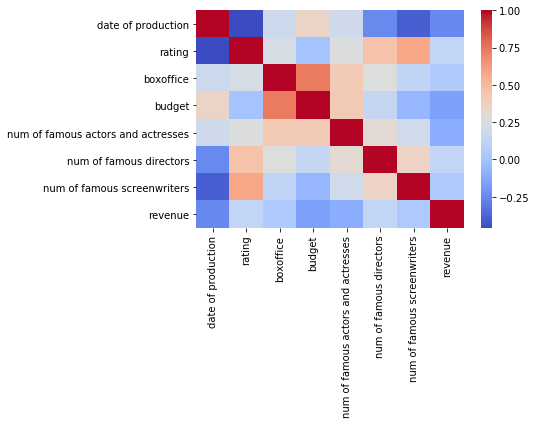

In [56]:
sns.heatmap(df[['date of production','rating','boxoffice','budget','num of famous actors and actresses',
                 'num of famous directors','num of famous screenwriters','revenue']].corr(), cmap='coolwarm')

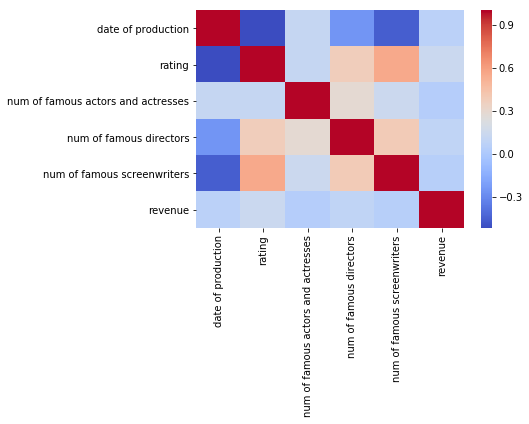

In [57]:
sns.heatmap(df1[['date of production','rating','num of famous actors and actresses',
                 'num of famous directors','num of famous screenwriters','revenue']].corr(), cmap='coolwarm')

We can see that the biggest impact on a rating has a number of famous directors and screenwriters, on the otehr hand a boxoffice and a budget have one of the least impacts so we will not use them for building a model. Now we will check how a mean rating and a revenue of a movies depends on a different variables.

In [58]:
lst=[]
for i in range(df1['rating'].count()):
    for j in range(5):
        try:
            country=df1['production'][i][j]
            if country not in lst:
                lst.append(country)
        except:
            continue
len(lst)

50

In [59]:
countries_mean_rating=pd.DataFrame([[0,0] for i in range(len(lst))])
for i in range(len(lst)):
    lst2=[] #list with rating
    for j in range(df1['rating'].count()):
        try:
            if lst[i] in df1['production'][j]:
                lst2.append(df1.loc[j]['rating'])
        except:
            continue
    countries_mean_rating.loc[i]=[lst[i], np.mean(lst2)]

In [60]:
countries_mean_rating=countries_mean_rating.rename(columns={0:'country', 1:'mean rating'})

In [61]:
#creating a column 'num_of_movies' which represents how many movies was produced by a given country
countries_mean_rating['num_of_movies']=0

In [62]:
for i in range(len(lst)):
    country=lst[i]
    num_of_movies=0
    for j in range(df1['rating'].count()):
        if country in df1['production'][j]:
            num_of_movies+=1
    countries_mean_rating['num_of_movies'][i]=num_of_movies

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [63]:
countries_mean_rating.sort_values(by='mean rating',axis=0, ascending=False)

,country,mean rating,num_of_movies
45,Liban,8.300000,1
44,Brazylia,8.250000,2
46,RPA,8.200000,1
49,Indie,8.100000,1
48,Estonia,8.100000,1
47,Gruzja,8.100000,1
40,RFN,8.066667,3
42,ZSRR,8.000000,3
41,Czechosłowacja,7.900000,1
43,Szwajcaria,7.900000,1


We see that countries which have the biggest mean rating have also very little number of movies produced, from among 8 countries which have produced the most movies, Italy has the biggest mean rating.

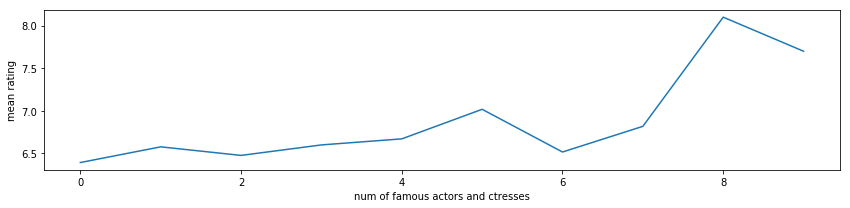

In [64]:
fig,axes = plt.subplots(figsize=(12,3))
axes.plot(df1.groupby('num of famous actors and actresses').mean()['rating'])
axes.set_ylabel('mean rating')
axes.set_xlabel('num of famous actors and ctresses')
plt.tight_layout()

A number of famous actors doesn't seem to have a big impact on a rating, only movies with 8 and 9 famous actors has significantly bigger mean rating.

In [65]:
pd.DataFrame(df1.groupby('num of famous directors').mean().sort_values('rating',ascending=False)['rating'])

,rating
num of famous directors,
1,7.384932
2,7.366667
0,6.210059


In [66]:
pd.DataFrame(df1.groupby('num of famous screenwriters').mean().sort_values('rating',ascending=False)['rating'])

,rating
num of famous screenwriters,
2,7.985106
1,7.605085
0,5.983230


We can see that if we have at least one famous screenwriter or director then a mean rating is much bigger, but there is no difference if we have one or two famous screenwriters or directors.

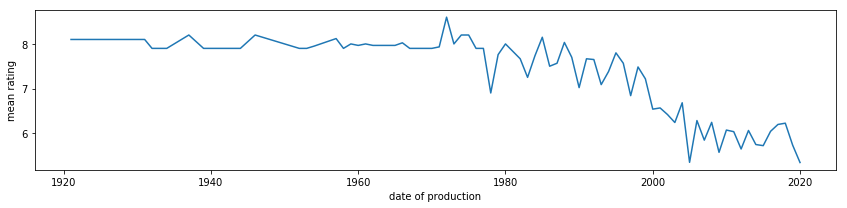

In [67]:
fig,axes=plt.subplots(figsize=(12,3))
axes.plot(df1.groupby('date of production').mean()['rating'])
axes.set_xlabel('date of production')
axes.set_ylabel('mean rating')
plt.tight_layout()

The movies produced after around 1980 start to getting smaller mean rate and the biggest drop is between 2019 and 2020. Let's check a number of movies with rating above 7.5 which was produced before and after 1980.

In [68]:
print('Number of movies with rating above 7.5 produced after 1980: {}'
      .format(df1[(df1['date of production']>1980)&(df1['rating']>7.5)]['rating'].count()))

Number of movies with rating above 7.5 produced after 1980: 113


In [69]:
print('Number of movies with rating above 7.5 produced before 1980: {}'
      .format(df1[(df1['date of production']<1980)&(df1['rating']>7.5)]['rating'].count()))

Number of movies with rating above 7.5 produced before 1980: 67


We can see that even though a mean rating of movies produced after 1980 start to getting smaller, a number of movies with a rating above 7.5 is almost two times bigger. Now let's see what are the movies with the biggest revenue and how it depends on a number of famous actors, screenwriters and directors.

In [75]:
df[['title','revenue']].sort_values(by='revenue',ascending=False)

,title,revenue
151,El mariachi,291.704000
155,Mad Max,153.846154
176,Przeminęło z wiatrem,101.169872
124,Świt żywych trupów,84.615385
163,Gwiezdne wojny: Część IV - Nowa nadzieja,70.501945
254,Psychoza,61.961938
140,Cztery wesela i pogrzeb,55.841098
200,Ojciec chrzestny,40.844402
178,Absolwent,38.315102
8,Ostatni egzorcyzm,37.632272


In [71]:
pd.DataFrame(df.groupby('num of famous actors and actresses').mean().sort_values('revenue',ascending=False)['revenue'])

,revenue
num of famous actors and actresses,
0,15.445307
1,10.049147
5,9.118001
7,8.559945
9,6.401505
3,5.670429
8,5.664096
4,5.546224
2,5.531399


In [72]:
pd.DataFrame(df.groupby('num of famous directors').mean().sort_values('revenue',ascending=False)['revenue'])

,revenue
num of famous directors,
1,13.015288
0,5.875589
2,4.931307


In [73]:
pd.DataFrame(df.groupby('num of famous screenwriters').mean().sort_values('revenue',ascending=False)['revenue'])

,revenue
num of famous screenwriters,
1,10.804486
2,8.809716
0,7.465165


Now we will create some models and try to predict a rating of a movie. In order to check which one is the best we will calculate a root mean square error.

## model 1- Support Vector Regression

In [76]:
df=pd.read_csv('filmweb_data')
df1=pd.read_csv('filmweb_data2')

In [77]:
df1.drop(['Unnamed: 0','actors','premiere','production','directing','scenario','studio','title'],axis=1,inplace=True)
df.drop(['Unnamed: 0','actors','premiere','production','directing','scenario','studio','title'],axis=1,inplace=True)

In [78]:
x=df1.drop('rating',axis=1)
y=df1['rating']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

In [79]:
from sklearn import svm
regr = svm.SVR()
regr.fit(x_train,y_train)
pred=regr.predict(x_test)

from sklearn import metrics
import numpy as np
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

RMSE: 1.0513563850681167


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## model 2- KNeighborsRegressor

In [80]:
from sklearn.neighbors import KNeighborsRegressor
model=KNeighborsRegressor()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

RMSE: 1.0863932713967142


## model 3- GaussianProcessRegressor

In [81]:
from sklearn.gaussian_process import GaussianProcessRegressor
model=GaussianProcessRegressor()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

RMSE: 4.563772418555359


## model 4- DecisionTreeRegressor

In [82]:
from sklearn.tree import DecisionTreeRegressor
model=DecisionTreeRegressor()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

RMSE: 1.0869041099460832


We can see that the best one is Support Vector Regression. Let's try to improve it with GridSearch.

In [83]:
from sklearn.model_selection import GridSearchCV

In [84]:
param={'C':[0.001,0.01,0.1,1,10,100,1000],'epsilon':[0.001,0.01,0.1,1,10,100,1000]}
grid = GridSearchCV(svm.SVR(),param,refit=True,verbose=3)

In [85]:
grid.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid th

Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV] C=0.001, epsilon=0.001 ..........................................
[CV]  C=0.001, epsilon=0.001, score=-0.06535862613818355, total=   0.0s
[CV] C=0.001, epsilon=0.001 ..........................................
[CV]  C=0.001, epsilon=0.001, score=-0.025715369735804794, total=   0.0s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] C=0.001, epsilon=0.001 ..........................................
[CV]  C=0.001, epsilon=0.001, score=-0.030000498693876887, total=   0.0s
[CV] C=0.001, epsilon=0.01 ...........................................
[CV]  C=0.001, epsilon=0.01, score=-0.06476983970262684, total=   0.0s
[CV] C=0.001, epsilon=0.01 ...........................................
[CV]  C=0.001, epsilon=0.01, score=-0.02442583858407832, total=   0.0s
[CV] C=0.001, epsilon=0.01 ...........................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV]  C=0.001, epsilon=0.01, score=-0.027954085729440914, total=   0.0s
[CV] C=0.001, epsilon=0.1 ............................................
[CV] . C=0.001, epsilon=0.1, score=-0.03083797902111796, total=   0.0s
[CV] C=0.001, epsilon=0.1 ............................................
[CV]  C=0.001, epsilon=0.1, score=-0.005185787064288183, total=   0.0s
[CV] C=0.001, epsilon=0.1 ............................................
[CV]  C=0.001, epsilon=0.1, score=-0.0039713334274866785, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni


[CV] C=0.001, epsilon=1 ..............................................
[CV] ... C=0.001, epsilon=1, score=-0.06514370407789505, total=   0.0s
[CV] C=0.001, epsilon=1 ..............................................
[CV] .. C=0.001, epsilon=1, score=-0.030872879811769005, total=   0.0s
[CV] C=0.001, epsilon=1 ..............................................
[CV] ... C=0.001, epsilon=1, score=-0.02920609204318181, total=   0.0s
[CV] C=0.001, epsilon=10 .............................................
[CV] .. C=0.001, epsilon=10, score=-0.16216801566532935, total=   0.0s
[CV] C=0.001, epsilon=10 .............................................
[CV] .. C=0.001, epsilon=10, score=-0.17392444435364163, total=   0.0s
[CV] C=0.001, epsilon=10 .............................................
[CV] .. C=0.001, epsilon=10, score=-0.18318379680369556, total=   0.0s
[CV] C=0.001, epsilon=100 ............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

[CV] . C=0.001, epsilon=100, score=-0.16216801566532935, total=   0.0s
[CV] C=0.001, epsilon=100 ............................................
[CV] . C=0.001, epsilon=100, score=-0.17392444435364407, total=   0.0s
[CV] C=0.001, epsilon=100 ............................................
[CV] . C=0.001, epsilon=100, score=-0.18318379680369556, total=   0.0s
[CV] C=0.001, epsilon=1000 ...........................................
[CV]  C=0.001, epsilon=1000, score=-0.16216801566532935, total=   0.0s
[CV] C=0.001, epsilon=1000 ...........................................
[CV]  C=0.001, epsilon=1000, score=-0.17392444435364762, total=   0.0s
[CV] C=0.001, epsilon=1000 ...........................................
[CV]  C=0.001, epsilon=1000, score=-0.18318379680369556, total=   0.0s
[CV] C=0.01, epsilon=0.001 ...........................................
[CV] . C=0.01, epsilon=0.001, score=0.05246528616185997, total=   0.0s
[CV] C=0.01, epsilon=0.001 ...........................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] . C=0.01, epsilon=0.001, score=0.08777221678834579, total=   0.0s
[CV] C=0.01, epsilon=0.001 ...........................................
[CV] .. C=0.01, epsilon=0.001, score=0.0656643942914269, total=   0.0s
[CV] C=0.01, epsilon=0.01 ............................................
[CV] .. C=0.01, epsilon=0.01, score=0.05326109215678776, total=   0.0s
[CV] C=0.01, epsilon=0.01 ............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .... C=0.01, epsilon=0.01, score=0.087798861435328, total=   0.0s
[CV] C=0.01, epsilon=0.01 ............................................
[CV] .. C=0.01, epsilon=0.01, score=0.06448162580900008, total=   0.0s
[CV] C=0.01, epsilon=0.1 .............................................
[CV] .. C=0.01, epsilon=0.1, score=0.057853906411568616, total=   0.0s
[CV] C=0.01, epsilon=0.1 .............................................
[CV] ... C=0.01, epsilon=0.1, score=0.09868212325460946, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



[CV] C=0.01, epsilon=0.1 .............................................
[CV] ... C=0.01, epsilon=0.1, score=0.08357998014594037, total=   0.0s
[CV] C=0.01, epsilon=1 ...............................................
[CV] ..... C=0.01, epsilon=1, score=0.05372077308260881, total=   0.0s
[CV] C=0.01, epsilon=1 ...............................................
[CV] ..... C=0.01, epsilon=1, score=0.04714959374536298, total=   0.0s
[CV] C=0.01, epsilon=1 ...............................................
[CV] ..... C=0.01, epsilon=1, score=0.07227720658974858, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni


[CV] C=0.01, epsilon=10 ..............................................
[CV] ... C=0.01, epsilon=10, score=-0.16216801566532935, total=   0.0s
[CV] C=0.01, epsilon=10 ..............................................
[CV] ... C=0.01, epsilon=10, score=-0.17392444435364163, total=   0.0s
[CV] C=0.01, epsilon=10 ..............................................
[CV] ... C=0.01, epsilon=10, score=-0.18318379680369556, total=   0.0s
[CV] C=0.01, epsilon=100 .............................................
[CV] .. C=0.01, epsilon=100, score=-0.16216801566532935, total=   0.0s
[CV] C=0.01, epsilon=100 .............................................
[CV] .. C=0.01, epsilon=100, score=-0.17392444435364407, total=   0.0s
[CV] C=0.01, epsilon=100 .............................................
[CV] .. C=0.01, epsilon=100, score=-0.18318379680369556, total=   0.0s
[CV] C=0.01, epsilon=1000 ............................................
[CV] . C=0.01, epsilon=1000, score=-0.16216801566532935, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni


[CV] C=0.1, epsilon=0.001 ............................................
[CV] ... C=0.1, epsilon=0.001, score=0.3352372735387248, total=   0.0s
[CV] C=0.1, epsilon=0.001 ............................................
[CV] ... C=0.1, epsilon=0.001, score=0.3573496676443634, total=   0.0s
[CV] C=0.1, epsilon=0.01 .............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ... C=0.1, epsilon=0.01, score=0.28038072442938566, total=   0.0s
[CV] C=0.1, epsilon=0.01 .............................................
[CV] .... C=0.1, epsilon=0.01, score=0.3342030221448927, total=   0.0s
[CV] C=0.1, epsilon=0.01 .............................................
[CV] .... C=0.1, epsilon=0.01, score=0.3561812107809148, total=   0.0s
[CV] C=0.1, epsilon=0.1 ..............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .... C=0.1, epsilon=0.1, score=0.28174778467072314, total=   0.0s
[CV] C=0.1, epsilon=0.1 ..............................................
[CV] .... C=0.1, epsilon=0.1, score=0.33021617161675787, total=   0.0s
[CV] C=0.1, epsilon=0.1 ..............................................
[CV] .... C=0.1, epsilon=0.1, score=0.35650505087661055, total=   0.0s
[CV] C=0.1, epsilon=1 ................................................
[CV] ........ C=0.1, epsilon=1, score=0.217603331676273, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni


[CV] C=0.1, epsilon=1 ................................................
[CV] ....... C=0.1, epsilon=1, score=0.2720848612326947, total=   0.0s
[CV] C=0.1, epsilon=1 ................................................
[CV] ...... C=0.1, epsilon=1, score=0.29309448810757877, total=   0.0s
[CV] C=0.1, epsilon=10 ...............................................
[CV] .... C=0.1, epsilon=10, score=-0.16216801566532935, total=   0.0s
[CV] C=0.1, epsilon=10 ...............................................
[CV] .... C=0.1, epsilon=10, score=-0.17392444435364163, total=   0.0s
[CV] C=0.1, epsilon=10 ...............................................
[CV] .... C=0.1, epsilon=10, score=-0.18318379680369556, total=   0.0s
[CV] C=0.1, epsilon=100 ..............................................
[CV] ... C=0.1, epsilon=100, score=-0.16216801566532935, total=   0.0s
[CV] C=0.1, epsilon=100 ..............................................
[CV] ... C=0.1, epsilon=100, score=-0.17392444435364407, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

[CV] ... C=0.1, epsilon=100, score=-0.18318379680369556, total=   0.0s
[CV] C=0.1, epsilon=1000 .............................................
[CV] .. C=0.1, epsilon=1000, score=-0.16216801566532935, total=   0.0s
[CV] C=0.1, epsilon=1000 .............................................
[CV] .. C=0.1, epsilon=1000, score=-0.17392444435364762, total=   0.0s
[CV] C=0.1, epsilon=1000 .............................................
[CV] .. C=0.1, epsilon=1000, score=-0.18318379680369556, total=   0.0s
[CV] C=1, epsilon=0.001 ..............................................
[CV] .... C=1, epsilon=0.001, score=0.34894833110526813, total=   0.0s
[CV] C=1, epsilon=0.001 ..............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .... C=1, epsilon=0.001, score=0.38634718999308726, total=   0.0s
[CV] C=1, epsilon=0.001 ..............................................
[CV] ..... C=1, epsilon=0.001, score=0.4272222035526908, total=   0.0s
[CV] C=1, epsilon=0.01 ...............................................
[CV] ...... C=1, epsilon=0.01, score=0.3485320267641346, total=   0.0s
[CV] C=1, epsilon=0.01 ...............................................
[CV] ...... C=1, epsilon=0.01, score=0.3872459871606385, total=   0.0s
[CV] C=1, epsilon=0.01 ...............................................
[CV] ...... C=1, epsilon=0.01, score=0.4277515186233387, total=   0.0s
[CV] C=1, epsilon=0.1 ................................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ....... C=1, epsilon=0.1, score=0.3468103244483955, total=   0.0s
[CV] C=1, epsilon=0.1 ................................................
[CV] ...... C=1, epsilon=0.1, score=0.38734997304573904, total=   0.0s
[CV] C=1, epsilon=0.1 ................................................
[CV] ...... C=1, epsilon=0.1, score=0.42673273591576577, total=   0.0s
[CV] C=1, epsilon=1 ..................................................
[CV] ........ C=1, epsilon=1, score=0.30056779248071686, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



[CV] C=1, epsilon=1 ..................................................
[CV] ......... C=1, epsilon=1, score=0.3475394554579234, total=   0.0s
[CV] C=1, epsilon=1 ..................................................
[CV] ........ C=1, epsilon=1, score=0.38061411052728933, total=   0.0s
[CV] C=1, epsilon=10 .................................................
[CV] ...... C=1, epsilon=10, score=-0.16216801566532935, total=   0.0s
[CV] C=1, epsilon=10 .................................................
[CV] ...... C=1, epsilon=10, score=-0.17392444435364163, total=   0.0s
[CV] C=1, epsilon=10 .................................................
[CV] ...... C=1, epsilon=10, score=-0.18318379680369556, total=   0.0s
[CV] C=1, epsilon=100 ................................................
[CV] ..... C=1, epsilon=100, score=-0.16216801566532935, total=   0.0s
[CV] C=1, epsilon=100 ................................................
[CV] ..... C=1, epsilon=100, score=-0.17392444435364407, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni


[CV] C=1, epsilon=1000 ...............................................
[CV] .... C=1, epsilon=1000, score=-0.16216801566532935, total=   0.0s
[CV] C=1, epsilon=1000 ...............................................
[CV] .... C=1, epsilon=1000, score=-0.17392444435364762, total=   0.0s
[CV] C=1, epsilon=1000 ...............................................
[CV] .... C=1, epsilon=1000, score=-0.18318379680369556, total=   0.0s
[CV] C=10, epsilon=0.001 .............................................
[CV] .... C=10, epsilon=0.001, score=0.5055799444662948, total=   0.0s
[CV] C=10, epsilon=0.001 .............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

[CV] .... C=10, epsilon=0.001, score=0.5715973129924978, total=   0.0s
[CV] C=10, epsilon=0.001 .............................................
[CV] .... C=10, epsilon=0.001, score=0.6040248398584336, total=   0.0s
[CV] C=10, epsilon=0.01 ..............................................
[CV] ..... C=10, epsilon=0.01, score=0.5046080369160356, total=   0.0s
[CV] C=10, epsilon=0.01 ..............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ..... C=10, epsilon=0.01, score=0.5709659137729306, total=   0.0s
[CV] C=10, epsilon=0.01 ..............................................
[CV] ..... C=10, epsilon=0.01, score=0.6039128197678307, total=   0.0s
[CV] C=10, epsilon=0.1 ...............................................
[CV] ..... C=10, epsilon=0.1, score=0.49797443969094946, total=   0.0s
[CV] C=10, epsilon=0.1 ...............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ....... C=10, epsilon=0.1, score=0.570504013677654, total=   0.0s
[CV] C=10, epsilon=0.1 ...............................................
[CV] ...... C=10, epsilon=0.1, score=0.6095570766571545, total=   0.0s
[CV] C=10, epsilon=1 .................................................
[CV] ........ C=10, epsilon=1, score=0.4513697906276066, total=   0.0s
[CV] C=10, epsilon=1 .................................................
[CV] ....... C=10, epsilon=1, score=0.46568756315952775, total=   0.0s
[CV] C=10, epsilon=1 .................................................
[CV] ......... C=10, epsilon=1, score=0.509844168561389, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni


[CV] C=10, epsilon=10 ................................................
[CV] ..... C=10, epsilon=10, score=-0.16216801566532935, total=   0.0s
[CV] C=10, epsilon=10 ................................................
[CV] ..... C=10, epsilon=10, score=-0.17392444435364163, total=   0.0s
[CV] C=10, epsilon=10 ................................................
[CV] ..... C=10, epsilon=10, score=-0.18318379680369556, total=   0.0s
[CV] C=10, epsilon=100 ...............................................
[CV] .... C=10, epsilon=100, score=-0.16216801566532935, total=   0.0s
[CV] C=10, epsilon=100 ...............................................
[CV] .... C=10, epsilon=100, score=-0.17392444435364407, total=   0.0s
[CV] C=10, epsilon=100 ...............................................
[CV] .... C=10, epsilon=100, score=-0.18318379680369556, total=   0.0s
[CV] C=10, epsilon=1000 ..............................................
[CV] ... C=10, epsilon=1000, score=-0.16216801566532935, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

[CV] .. C=100, epsilon=0.001, score=0.38161207893096377, total=   0.0s
[CV] C=100, epsilon=0.001 ............................................
[CV] .... C=100, epsilon=0.001, score=0.572152828897474, total=   0.0s
[CV] C=100, epsilon=0.001 ............................................
[CV] ... C=100, epsilon=0.001, score=0.5589397741225806, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



[CV] C=100, epsilon=0.01 .............................................
[CV] .... C=100, epsilon=0.01, score=0.3821946974081332, total=   0.0s
[CV] C=100, epsilon=0.01 .............................................
[CV] .... C=100, epsilon=0.01, score=0.5714642331246087, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



[CV] C=100, epsilon=0.01 .............................................
[CV] .... C=100, epsilon=0.01, score=0.5595183349811534, total=   0.0s
[CV] C=100, epsilon=0.1 ..............................................
[CV] ..... C=100, epsilon=0.1, score=0.3985900633408291, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



[CV] C=100, epsilon=0.1 ..............................................
[CV] ..... C=100, epsilon=0.1, score=0.5625156135495146, total=   0.0s
[CV] C=100, epsilon=0.1 ..............................................
[CV] ..... C=100, epsilon=0.1, score=0.5618275293979329, total=   0.0s
[CV] C=100, epsilon=1 ................................................
[CV] ....... C=100, epsilon=1, score=0.4606842025322482, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



[CV] C=100, epsilon=1 ................................................
[CV] ....... C=100, epsilon=1, score=0.5355597560672488, total=   0.0s
[CV] C=100, epsilon=1 ................................................
[CV] ....... C=100, epsilon=1, score=0.5151349469895483, total=   0.0s
[CV] C=100, epsilon=10 ...............................................
[CV] .... C=100, epsilon=10, score=-0.16216801566532935, total=   0.0s
[CV] C=100, epsilon=10 ...............................................
[CV] .... C=100, epsilon=10, score=-0.17392444435364163, total=   0.0s
[CV] C=100, epsilon=10 ...............................................
[CV] .... C=100, epsilon=10, score=-0.18318379680369556, total=   0.0s
[CV] C=100, epsilon=100 ..............................................
[CV] ... C=100, epsilon=100, score=-0.16216801566532935, total=   0.0s
[CV] C=100, epsilon=100 ..............................................
[CV] ... C=100, epsilon=100, score=-0.17392444435364407, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni


[CV] C=100, epsilon=1000 .............................................
[CV] .. C=100, epsilon=1000, score=-0.18318379680369556, total=   0.0s
[CV] C=1000, epsilon=0.001 ...........................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] . C=1000, epsilon=0.001, score=0.15851022985538643, total=   0.1s
[CV] C=1000, epsilon=0.001 ...........................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] . C=1000, epsilon=0.001, score=0.40583611916683504, total=   0.1s
[CV] C=1000, epsilon=0.001 ...........................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] . C=1000, epsilon=0.001, score=0.32757194585757965, total=   0.1s
[CV] C=1000, epsilon=0.01 ............................................
[CV] .. C=1000, epsilon=0.01, score=0.16321779119539315, total=   0.0s
[CV] C=1000, epsilon=0.01 ............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .. C=1000, epsilon=0.01, score=0.40767123118375725, total=   0.1s
[CV] C=1000, epsilon=0.01 ............................................
[CV] .. C=1000, epsilon=0.01, score=0.33215417814990655, total=   0.1s
[CV] C=1000, epsilon=0.1 .............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ... C=1000, epsilon=0.1, score=0.19753152700492427, total=   0.0s
[CV] C=1000, epsilon=0.1 .............................................
[CV] .... C=1000, epsilon=0.1, score=0.4181043704511297, total=   0.0s
[CV] C=1000, epsilon=0.1 .............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .... C=1000, epsilon=0.1, score=0.3615644473451922, total=   0.0s
[CV] C=1000, epsilon=1 ...............................................
[CV] ...... C=1000, epsilon=1, score=0.4208918335217823, total=   0.0s
[CV] C=1000, epsilon=1 ...............................................
[CV] ...... C=1000, epsilon=1, score=0.5375376894326688, total=   0.0s
[CV] C=1000, epsilon=1 ...............................................
[CV] ...... C=1000, epsilon=1, score=0.5185349731388766, total=   0.0s
[CV] C=1000, epsilon=10 ..............................................
[CV] ... C=1000, epsilon=10, score=-0.16216801566532935, total=   0.0s
[CV] C=1000, epsilon=10 ..............................................
[CV] ... C=1000, epsilon=10, score=-0.17392444435364163, total=   0.0s
[CV] C=1000, epsilon=10 ..............................................
[CV] ... C=1000, epsilon=10, score=-0.18318379680369556, total=   0.0s
[CV] C=1000, epsilon=100 .............................................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

[CV] . C=1000, epsilon=1000, score=-0.16216801566532935, total=   0.0s
[CV] C=1000, epsilon=1000 ............................................
[CV] . C=1000, epsilon=1000, score=-0.17392444435364762, total=   0.0s
[CV] C=1000, epsilon=1000 ............................................
[CV] . C=1000, epsilon=1000, score=-0.18318379680369556, total=   0.0s


[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    7.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'epsilon': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [86]:
grid.best_params_

{'C': 10, 'epsilon': 0.001}

In [87]:
pred=grid.predict(x_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

RMSE: 0.9364084948998318


Now let's try classification models. In order to do that, we will round up rating values so a type of them is int.

In [88]:
df1['rating'].value_counts()

5.9    93
6.9    93
7.9    92
8.1    46
4.7    25
4.9    24
4.8    20
8.2    17
8.3    13
4.6    12
4.5    10
3.8     6
8.0     4
8.4     4
3.5     4
3.3     3
3.6     3
3.9     3
4.4     3
8.5     3
8.7     2
8.6     2
3.7     2
3.2     1
8.8     1
3.4     1
Name: rating, dtype: int64

In [89]:
for i in range(df1['rating'].count()):
    if 3<=df1['rating'][i]<=3.4:
        df1['rating'][i]=3
    elif 3.5<=df1['rating'][i]<=4.4:
        df1['rating'][i]=4
    elif 4.5<=df1['rating'][i]<=5.4:
        df1['rating'][i]=5
    elif 5.5<=df1['rating'][i]<=6.4:
        df1['rating'][i]=6
    elif 6.5<=df1['rating'][i]<7.4:
        df1['rating'][i]=7
    elif 7.5<=df1['rating'][i]<=8.4:
        df1['rating'][i]=8
    else:
        df1['rating'][i]=9

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_

In [90]:
df1['rating'].value_counts()

8.0    176
7.0     93
6.0     93
5.0     91
4.0     21
9.0      8
3.0      5
Name: rating, dtype: int64

In [91]:
x=df1.drop('rating',axis=1)
y=df1['rating']

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.3)

## model 1- KNN

In [92]:
from sklearn.neighbors import KNeighborsClassifier
error=[]
for i in range(50):
    model=KNeighborsClassifier(n_neighbors=i+1)
    model.fit(x_train,y_train)
    pred=model.predict(x_test)
    error.append(np.mean(np.array(pred)!=np.array(y_test)))


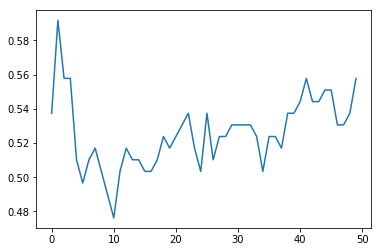

In [93]:
plt.plot(error)

In [94]:
model=KNeighborsClassifier(n_neighbors=49)
model.fit(x_train,y_train)
pred=model.predict(x_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[ 0  4  2  1  0  0]
 [ 0 19  1 10  2  0]
 [ 0 10  6 16  3  0]
 [ 0  3  2  5  9  0]
 [ 0  5  2  8 38  0]
 [ 0  0  0  0  1  0]]
              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         7
         5.0       0.46      0.59      0.52        32
         6.0       0.46      0.17      0.25        35
         7.0       0.12      0.26      0.17        19
         8.0       0.72      0.72      0.72        53
         9.0       0.00      0.00      0.00         1

   micro avg       0.46      0.46      0.46       147
   macro avg       0.29      0.29      0.28       147
weighted avg       0.49      0.46      0.45       147



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## model 2- SVC

In [95]:
from sklearn.svm import SVC
model=SVC()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[ 0  6  0  1  0  0]
 [ 0 19  0 11  2  0]
 [ 0 13  0 19  3  0]
 [ 0  4  0  6  9  0]
 [ 0  4  0 10 39  0]
 [ 0  0  0  0  1  0]]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         7
         5.0       0.41      0.59      0.49        32
         6.0       0.00      0.00      0.00        35
         7.0       0.13      0.32      0.18        19
         8.0       0.72      0.74      0.73        53
         9.0       0.00      0.00      0.00         1

   micro avg       0.44      0.44      0.44       147
   macro avg       0.21      0.27      0.23       147
weighted avg       0.37      0.44      0.39       147



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## model 3- SGDC

In [96]:
from sklearn.linear_model import SGDClassifier
model=SGDClassifier()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[ 0  7  0  0  0  0]
 [ 0 32  0  0  0  0]
 [ 0 35  0  0  0  0]
 [ 0 19  0  0  0  0]
 [ 0 53  0  0  0  0]
 [ 0  1  0  0  0  0]]
              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         7
         5.0       0.22      1.00      0.36        32
         6.0       0.00      0.00      0.00        35
         7.0       0.00      0.00      0.00        19
         8.0       0.00      0.00      0.00        53
         9.0       0.00      0.00      0.00         1

   micro avg       0.22      0.22      0.22       147
   macro avg       0.04      0.17      0.06       147
weighted avg       0.05      0.22      0.08       147



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## model 4- GaussianNB

In [97]:
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[ 0  0  0  0  0  0  0]
 [ 2  5  0  0  0  0  0]
 [ 7 10  5  1  3  2  4]
 [ 9  2  7  6  1  3  7]
 [ 2  0  4  3  3  0  7]
 [ 1  0  5 11 11 11 14]
 [ 0  0  0  0  0  0  1]]
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         0
         4.0       0.29      0.71      0.42         7
         5.0       0.24      0.16      0.19        32
         6.0       0.29      0.17      0.21        35
         7.0       0.17      0.16      0.16        19
         8.0       0.69      0.21      0.32        53
         9.0       0.03      1.00      0.06         1

   micro avg       0.21      0.21      0.21       147
   macro avg       0.24      0.34      0.19       147
weighted avg       0.40      0.21      0.25       147



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## model 5- Multinomial NB

In [98]:
from sklearn.naive_bayes import MultinomialNB
model=MultinomialNB()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[ 0  5  0  0  2  0]
 [ 0 16  0  1 15  0]
 [ 0  6  8  6 15  0]
 [ 0  0  1  6 12  0]
 [ 0  5  0  3 45  0]
 [ 0  0  0  0  1  0]]
              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         7
         5.0       0.50      0.50      0.50        32
         6.0       0.89      0.23      0.36        35
         7.0       0.38      0.32      0.34        19
         8.0       0.50      0.85      0.63        53
         9.0       0.00      0.00      0.00         1

   micro avg       0.51      0.51      0.51       147
   macro avg       0.38      0.32      0.31       147
weighted avg       0.55      0.51      0.47       147



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 ## model 6- Complement NB

In [99]:
from sklearn.naive_bayes import ComplementNB
model=ComplementNB()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[ 0  0  0  0  0  0  0]
 [ 0  0  5  0  1  1  0]
 [ 1  3 17  1  5  5  0]
 [ 1  0 15  8  4  7  0]
 [ 2  0  3  1  6  7  0]
 [ 0  5  5  1  3 39  0]
 [ 0  0  0  0  0  1  0]]
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         7
         5.0       0.38      0.53      0.44        32
         6.0       0.73      0.23      0.35        35
         7.0       0.32      0.32      0.32        19
         8.0       0.65      0.74      0.69        53
         9.0       0.00      0.00      0.00         1

   micro avg       0.48      0.48      0.48       147
   macro avg       0.30      0.26      0.26       147
weighted avg       0.53      0.48      0.47       147



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\sit

## model 7- Bernoulli NB

In [100]:
from sklearn.naive_bayes import BernoulliNB
model=ComplementNB()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[ 0  0  0  0  0  0  0]
 [ 0  0  5  0  1  1  0]
 [ 1  3 17  1  5  5  0]
 [ 1  0 15  8  4  7  0]
 [ 2  0  3  1  6  7  0]
 [ 0  5  5  1  3 39  0]
 [ 0  0  0  0  0  1  0]]
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         7
         5.0       0.38      0.53      0.44        32
         6.0       0.73      0.23      0.35        35
         7.0       0.32      0.32      0.32        19
         8.0       0.65      0.74      0.69        53
         9.0       0.00      0.00      0.00         1

   micro avg       0.48      0.48      0.48       147
   macro avg       0.30      0.26      0.26       147
weighted avg       0.53      0.48      0.47       147



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\sit

## model 7- Random Forest

In [101]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[ 0  0  0  0  0  0  0]
 [ 0  1  5  0  0  1  0]
 [ 0  1 20  5  4  2  0]
 [ 1  1 11  8  9  5  0]
 [ 1  0  0  3  7  8  0]
 [ 0  0  1  2  6 44  0]
 [ 0  0  0  0  0  1  0]]
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         0
         4.0       0.33      0.14      0.20         7
         5.0       0.54      0.62      0.58        32
         6.0       0.44      0.23      0.30        35
         7.0       0.27      0.37      0.31        19
         8.0       0.72      0.83      0.77        53
         9.0       0.00      0.00      0.00         1

   micro avg       0.54      0.54      0.54       147
   macro avg       0.33      0.31      0.31       147
weighted avg       0.53      0.54      0.53       147



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-p

## model 8- Logistic Regression

In [102]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[ 0  6  0  0  1  0]
 [ 0 16  1  8  7  0]
 [ 0 11 10  9  5  0]
 [ 0  1  1 11  6  0]
 [ 0  0  2  9 42  0]
 [ 0  0  0  0  1  0]]
              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         7
         5.0       0.47      0.50      0.48        32
         6.0       0.71      0.29      0.41        35
         7.0       0.30      0.58      0.39        19
         8.0       0.68      0.79      0.73        53
         9.0       0.00      0.00      0.00         1

   micro avg       0.54      0.54      0.54       147
   macro avg       0.36      0.36      0.34       147
weighted avg       0.56      0.54      0.52       147



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\me

## model 9- Decission Tree

In [103]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[ 0  0  0  0  0  0  0]
 [ 0  2  3  1  0  1  0]
 [ 1  5 14  5  7  0  0]
 [ 1  5  6  9 11  3  0]
 [ 0  0  2  3  9  5  0]
 [ 0  1  4  2  6 38  2]
 [ 0  0  0  0  0  1  0]]
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         0
         4.0       0.15      0.29      0.20         7
         5.0       0.48      0.44      0.46        32
         6.0       0.45      0.26      0.33        35
         7.0       0.27      0.47      0.35        19
         8.0       0.79      0.72      0.75        53
         9.0       0.00      0.00      0.00         1

   micro avg       0.49      0.49      0.49       147
   macro avg       0.31      0.31      0.30       147
weighted avg       0.54      0.49      0.50       147



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## model 10- Gaussian Process

In [104]:
from sklearn.gaussian_process import GaussianProcessClassifier
model=GaussianProcessClassifier()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[ 1  4  1  0  1  0]
 [ 2 15  7  6  2  0]
 [ 0  7 14 10  4  0]
 [ 0  2  5  4  8  0]
 [ 0  6  2  7 36  2]
 [ 0  0  0  0  1  0]]
              precision    recall  f1-score   support

         4.0       0.33      0.14      0.20         7
         5.0       0.44      0.47      0.45        32
         6.0       0.48      0.40      0.44        35
         7.0       0.15      0.21      0.17        19
         8.0       0.69      0.68      0.69        53
         9.0       0.00      0.00      0.00         1

   micro avg       0.48      0.48      0.48       147
   macro avg       0.35      0.32      0.33       147
weighted avg       0.50      0.48      0.48       147



It's quite diffucult to decide which model is the best. The logistic regression has the highest average f1- score but some of the other models are better for predicting some ratings, for example for predicting rating 4 the highest f1- score has the GaussianNB model which amounts 0.25.